# N225 Japan Index trading

### Due to CUDA support I'm editing this notebook at google colab - I'll refresh this notebook when I'll get some results

### Import dependecies 

In [1]:
import gym
import gym_anytrading
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum

import tensorboard

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import A2C
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

import pandas as pd
from matplotlib import pyplot as plt
from typing import Callable, Dict, List, Optional, Tuple, Type, Union

import torch as th
from torch import nn

from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

from finta import TA
from gym_anytrading.envs import StocksEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

import os

import torch

### Data processing

In [2]:
df = pd.read_csv('data/N225.csv')

In [3]:
df.dropna(inplace=True)

In [4]:
df.dropna(inplace=True)
df['RSI'] = TA.RSI(df)
df['SMA'] = TA.SMA(df,14)
df['ATR'] = TA.ATR(df)
df.dropna(inplace=True)

In [5]:
# Load your financial data into a DataFrame (replace with your own data)
# df = pd.read_csv('your_data.csv')

# Calculate the top 20 technical analysis metrics
sma = TA.SMA(df,20)
ema = TA.EMA(df,20)
rsi = TA.RSI(df,14)
macd = TA.MACD(df)
upper, mid, lower = TA.BBANDS(df)
atr = TA.ATR(df)
stoch = TA.STOCH(df)
cci = TA.CCI(df)
roc = TA.ROC(df)
obv = TA.OBV(df)
adx = TA.ADX(df)
# cmf = TA.CMF(df)
uo = TA.UO(df)
wr = TA.WILLIAMS(df)
# sar = TA.PSAR(df)
# upper, mid, lower = TA.MAE(df['Close'], period=20, percent=0.1)
# conversion_line, base_line, leading_span_A, leading_span_B, lagging_span = TA.ICHIMOKU(df['High'], df['Low'])
adx = TA.ADX(df)
mfi = TA.MFI(df)
# co = TA.CHO(df)
# Combine all the metrics into a single DataFrame
all_metrics_df= pd.DataFrame({
    'SMA': sma,
    'EMA': ema,
    'RSI': rsi,
    'MACD': macd.MACD,
    'MACD_SIGNAL' : macd.SIGNAL,
    # # 'BBANDS_Upper': upper,
    # # 'BBANDS_Mid': mid,
    # # 'BBANDS_Lower': lower,
    'ATR': atr,
    'Stochastic': stoch,
    'CCI': cci,
    'ROC': roc,
    'OBV': obv,
    'ADX': adx,
    'UO': uo,
    'Williams %R': wr,
    'MFI': mfi
})

# Display the DataFrame with all the calculated metrics
# print(all_metrics_df.tail())
df = df.merge(all_metrics_df, right_index=True, left_index=True)

In [6]:
df.dropna(inplace=True)

### Creating my enviorment for AnyTrading, such that I can use 3 positions as actions (Short, Hold, Long) 

Here is the stanrd implementation of TradingEnv, I'm adding just the hold position

In [7]:
class Actions(Enum):
    Sell = 0
    Hold = 1
    Buy = 2


class Positions(Enum):
    Short = 0
    Hold = 1
    Long = 2
    

def opposite(position: Positions , action: int) -> any:
    '''New opposite, so that it works with 3 actions, overwiev:
            When action is Sell, we either Go to Hold (when we bought earlier) or short (when position was flat before)
            
            When action is Buy, we conduct the same reasoning but in the oppiste way

            When the action is Hold we stay at current position
    
    '''
    
    action = Actions(action)
    if action == Actions.Sell:
            
        if position == Positions.Long:
            return Positions.Hold, False
        
        if position == Positions.Hold:
            return Positions.Short, True
        
        
    if action == Actions.Buy:
        if position == Positions.Short:
            return Positions.Hold, False
        
        if position == Positions.Hold:
            return Positions.Long, True
        
    return position, False
        

class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size):
        assert df.ndim == 2

        self.seed()
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64)

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Hold
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}
        return self._get_observation()


    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        self._position, trade = opposite(self._position, action)
        if trade:
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)

        return observation, step_reward, self._done, info


    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]


    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            elif position == Positions.Hold:
                color = 'blue'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        plt.pause(0.01)


    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        hold_ticks = [] 
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
            elif self._position_history[i] == Positions.Hold:
                hold_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(hold_ticks, self.prices[hold_ticks], 'bo')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        
        
    def close(self):
        plt.close()


    def save_rendering(self, filepath):
        plt.savefig(filepath)


    def pause_rendering(self):
        plt.show()


    def _process_data(self):
        raise NotImplementedError


    def _calculate_reward(self, action):
        raise NotImplementedError


    def _update_profit(self, action):
        raise NotImplementedError


    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

#### StocksEnv

Here I'm implementing StocksEnv such that it'll utilize Hold action also

In [8]:
# from .trading_env import TradingEnv, Actions, Positions


class StocksEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2

        self.frame_bound = frame_bound
        super().__init__(df, window_size)

        self.trade_fee_bid_percent = 0.003  # unit
        self.trade_fee_ask_percent = 0.003
        # # unit
        
        # self.trade_fee_bid_percent = 0  # unit
        # self.trade_fee_ask_percent = 0
    def _process_data(self):
        start = self.frame_bound[0] - self.window_size
        end = self.frame_bound[1]
        prices = self.df.loc[:,'Close'].to_numpy()[start:end]
        
        signal_features = self.df.iloc[:,~df.columns.isin(['Date','Close'])].to_numpy()[start:end]
        normalized_df=(signal_features-signal_features.min())/(signal_features.max()-signal_features.min())

        return prices, signal_features


#     def _process_data(self):
#         prices = self.df.loc[:, 'Close'].to_numpy()

#         prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
#         prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

#         diff = np.insert(np.diff(prices), 0, 0)
#         signal_features = np.column_stack((prices, diff))

#         return prices, signal_features


    def _calculate_reward(self, action):
        step_reward = 0
        trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            if self._position == Positions.Long:
                step_reward += price_diff
            elif self._position == Positions.Short:
                step_reward += -price_diff 

        return step_reward

    
# Is this actually correct? reutrn for short shuld be different I suppouse

    def _update_profit(self, action):
        trade = True
        
        if trade or self._done:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price
            elif self._position == Positions.Short:
                self._total_profit = (self._total_profit *(1 + (last_trade_price - current_price - self.trade_fee_bid_percent*last_trade_price - self.trade_fee_ask_percent*current_price ) / last_trade_price))

    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            if position == Positions.Long:
                current_price = self.prices[current_tick - 1]
                last_trade_price = self.prices[last_trade_tick]
                shares = profit / last_trade_price
                profit = shares * current_price
            last_trade_tick = current_tick - 1

        return 

## Creating custom LSTM model for trading

I create this custom model, becouse I assume, LSTM will work better then normal Neural net. 

 Architecture of this model may change, depending on the final results

In [24]:
class customLSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm=nn.LSTM(input_size,hidden_size,num_layers=2,bidirectional= True)#,batch_first=True)
        self.fully_connected=nn.Sequential(
            nn.Linear(hidden_size*2,4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(4096,2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048,1024),
            nn.BatchNorm1d(1024),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            # nn.Linear(2048,512),
            # nn.BatchNorm1d(512),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            # nn.Linear(512,1024),
            # nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024,output_size),
            nn.ReLU()
        )
    def forward(self,x):
        batch_size=x.shape[0]
        h0=torch.zeros(2*2,self.hidden_size).cuda()
        c0=torch.zeros(2*2,self.hidden_size).cuda()

        lstm_output, cels = self.lstm(x,(h0,c0))
        flatten_output=torch.flatten(lstm_output,start_dim=1)
        
        output=self.fully_connected(flatten_output)
        
        return output



In [25]:
# from stable_baselines3 import PPO
# from stable_baselines3.common.policies import ActorCriticPolicy


class CustomNetwork(nn.Module):
    """
    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 128,
        last_layer_dim_vf: int = 128,
    ):
        super(CustomNetwork, self).__init__()

        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        # Policy network
        # self.policy_net = nn.Sequential(
        #     nn.Linear(feature_dim, last_layer_dim_pi), nn.ReLU()
        # )
        
        self.policy_net = customLSTM(feature_dim,512,last_layer_dim_pi)
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, 512), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(512,256), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(256,256), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(256,128), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(128,last_layer_dim_vf), 
            nn.ReLU()
        )

    def forward(self, features: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        return self.policy_net(features), self.value_net(features)

    def forward_actor(self, features: th.Tensor) -> th.Tensor:
        return self.policy_net(features)

    def forward_critic(self, features: th.Tensor) -> th.Tensor:
        return self.value_net(features)


class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        lr_schedule: Callable[[float], float],
        net_arch: Optional[List[Union[int, Dict[str, List[int]]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        *args,
        **kwargs,
    ):

        super(CustomActorCriticPolicy, self).__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch,
            activation_fn,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )
        # Disable orthogonal initialization
        self.ortho_init = False

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)



## Creating the enviorment and declaring PPO model with custom LSTM net

In [26]:
env = StocksEnv(df=df,window_size = 14, frame_bound=(3000,5000))

In [27]:
save_path = os.path.join('Training', 'Saved_models_N225')
log_path = os.path.join('Training','Logs')
eval_callback = EvalCallback(env, 
                             eval_freq = 10000, 
                             verbose = 1, 
                             best_model_save_path = save_path)

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [29]:
count_parameters(customLSTM(16*30,1024,128))

56546432

In [31]:

model = PPO(CustomActorCriticPolicy, env, verbose=1,tensorboard_log = log_path)
%time model.learn(50000)#,callback = eval_callback)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to Training\Logs\PPO_2
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.99e+03  |
|    ep_rew_mean     | -6.94e+03 |
| time/              |           |
|    fps             | 194       |
|    iterations      | 1         |
|    time_elapsed    | 10        |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.99e+03      |
|    ep_rew_mean          | -2.26e+03     |
| time/                   |               |
|    fps                  | 111           |
|    iterations           | 2             |
|    time_elapsed         | 36            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 2.0943815e-05 |
|    clip_fraction        | 0           

info {'total_reward': -33049.95803599992, 'total_profit': 4.1769410111950204e-05, 'position': 0}


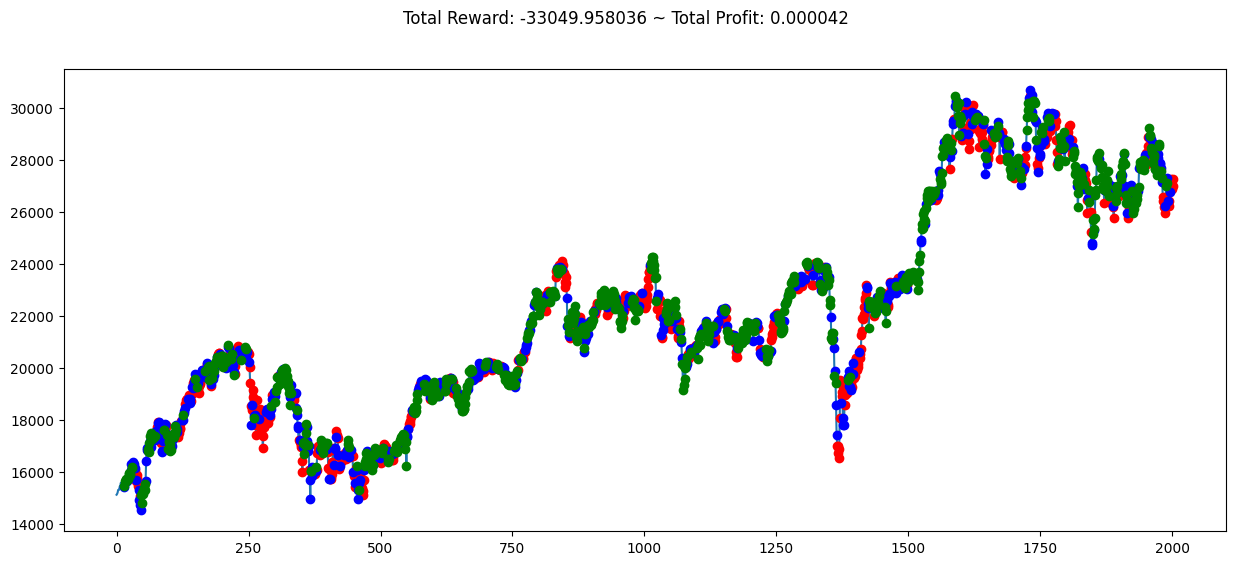

In [33]:
env = StocksEnv(df = df, frame_bound=(3000,5000), window_size = 14)
obs = env.reset()
while True:
    # obs = obs[np.newaxis, ...]
    # print(obs.shape)
    action, _states = model.predict(obs)
    obs,rewards,done,info = env.step(action)
    if done:
        print("info",info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [34]:
env = StocksEnv(df = df, frame_bound=(5014,5300), window_size = 14)
obs = env.reset()
while True:
    # obs = obs[np.newaxis, ...]
    # print(obs.shape)
    action, _states = model.predict(obs)
    obs,rewards,done,info = env.step(action)
    if done:
        print("info",info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity